In [3]:
%load_ext autoreload
%autoreload 2
%load_ext line_profiler
import numpy as np
import scipy
import matplotlib.pyplot as plt
import pywren
import seaborn as sns
import pandas as pd
from copy import deepcopy
from hinf_estimators import power_est, wahlberg_est, plugin_est, wts_est
from hinf_utils import hinfnorm_fir, make_simulator, pytry
from perf_profiles import perf_prof

## Sanity check experiments

In [38]:
# Sanity check from WTS paper
fcoeffs = np.array([0.102334455376235,  -0.120122390396804,  -0.051059886247146,  -0.230034413339248,
                    -0.051274569129089,   0.214928285792571,  -0.051274569129089,  -0.230034413339248,
                    -0.051059886247146,  -0.120122390396804,   0.102334455376235])
a = np.append(1,np.zeros(len(fcoeffs)-1))
b = fcoeffs
htrue, _ = hinfnorm_fir(fcoeffs)
g = fcoeffs

def sanity_check(estimator_fn, N_py, sig_base=None, N_base=None, r_base=None, **kwargs):
    # kwargs is a dict of extra stuff to pass
    save_hist = False
    sigs = np.round(sig_base * np.array([0, 0.1, 1, 10, 100]), decimals=3)
    fns = [make_simulator(g,sig) for sig in sigs]
    Ns = (N_base * np.array([.1,.25,.5,1,2])).astype(int)
    rs = (r_base * np.array([0.5,0.75,1.0,1.5,2.0])).astype(int)
    pows = [0.25, 0.5, 1.0, 1.5, 3.0]
    # Default arguments to pass in
    default_dict = {'fn': make_simulator(g,sig_base),
                    'N': N_base,
                    'r': r_base,
                    'power': 1.0}
    all_pars = {'fn': fns,
                'N': Ns,
                'r': rs,
                'power': pows}
    results = []
    strings = []
    
    for key in default_dict.keys():
        par_dict = deepcopy(default_dict)
        # a function taking in a parameter that returns a dict (don't think shallow copy matters here)
        arg_fn = lambda par: {k:(v if not k==key else par) for k,v in par_dict.items()}
        pyfn = lambda x: np.array([estimator_fn(**arg_fn(par), history=save_hist, **kwargs)
                                   for par in all_pars[key]])
        if key=='fn':
            strings.append(['_sig' + str(s) for s in sigs])
        else:
            strings.append(['_' + key + str(p) for p in all_pars[key]])
        results.append(pytry(pyfn, range(N_py)))
    return results, strings

In [41]:
# Plugin seems ok
# big_res, big_strings = sanity_check(plugin_est, sig_base=0.1, N_base=500, r_base=11)
# Power seems ok
# big_res, big_strings = sanity_check(power_est, 2000, sig_base=0.1, N_base=50, r_base=20)
# Wahl seems ok
# big_res, big_strings = sanity_check(wahlberg_est, 2000, sig_base=0.1, N_base=50, r_base=20)
# WTS seems ok
# big_res, big_strings = sanity_check(wts_est, 2000, sig_base=0.1, N_base=50, r_base=50)

OK
OK
OK
OK


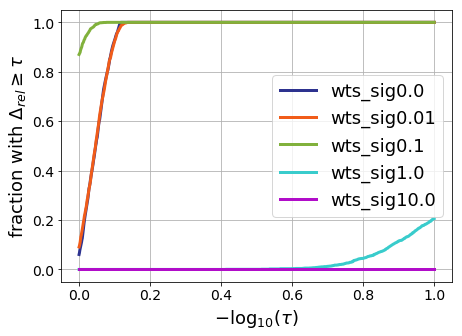

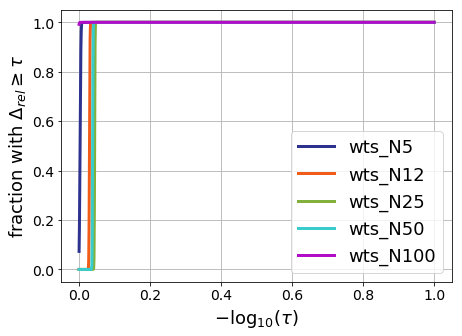

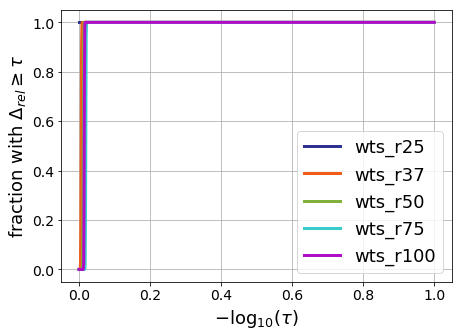

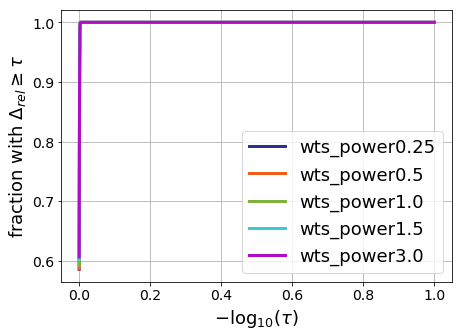

In [42]:
for ix in range(4):
    perf_prof(np.array(big_res[ix]), htrue, ['wts' + s for s in big_strings[ix]],tau_min=0.001,tau_max=1,npts=1000)

## Experiments for the paper

In [13]:
# Comparisons
def total_test(rho_t, power_t):
    # Need to fix everything beforehand
    sigma_t = 0.1
    N_t = 200
    # Systems will be FIR of length 10
    r_t = 50
#     power_t = 2.0

    #Random-ish systems
    def rand_sys(r,rho,sig=1):
        return rho**(np.arange(r)) * sig * 2 * (np.random.rand(r) - 0.5)

    rand_systems = np.array([rand_sys(10,rho_t,1) for k in range(100)])
    h_norms = [hinfnorm_fir(gk)[0] for gk in rand_systems]

    Nsamp = 10
    sys_rep = np.repeat(rand_systems, Nsamp, axis=0)
    h_rep = np.repeat(h_norms, Nsamp)

    def test_fn(g_t):
        fn_t = make_simulator(g_t, sigma_t)
        return np.array([plugin_est(fn=fn_t, N=N_t, r=r_t, power=power_t, history=False),
                         power_est(fn=fn_t, N=N_t, r=r_t, power=power_t, history=False),
                         wahlberg_est(fn=fn_t, N=N_t, r=r_t, power=power_t, history=False),
                         wts_est(fn=fn_t, N=N_t, r=r_t, power=power_t, history=False, sigma=sigma_t)])
    return sys_rep, h_rep, test_fn

In [14]:
# Run on pywren
big_res = []
big_sys = []
big_hs = []
pairs = [(0.75, 2.0), (0.75, 1.0), (1.0, 2.0), (1.0, 1.0)]
for p in pairs:
    rho_t = p[0]
    power_t = p[1]
    sys_rep, h_rep, test_fn = total_test(rho_t, power_t)
    big_res.append(np.array(pytry(test_fn, sys_rep)))
    big_sys.append(sys_rep)
    big_hs.append(h_rep)

OK
OK
OK
OK


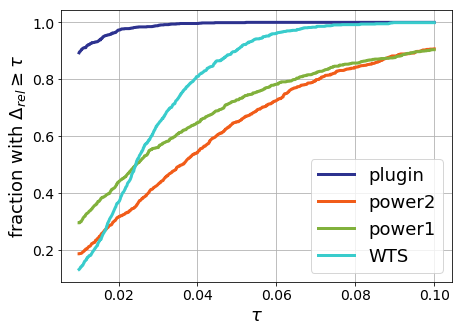

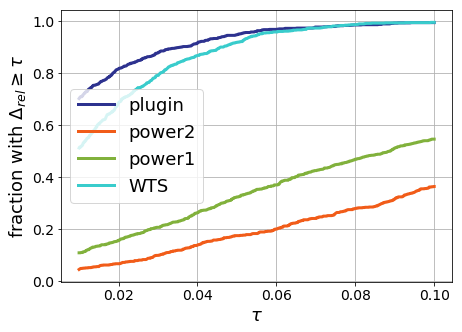

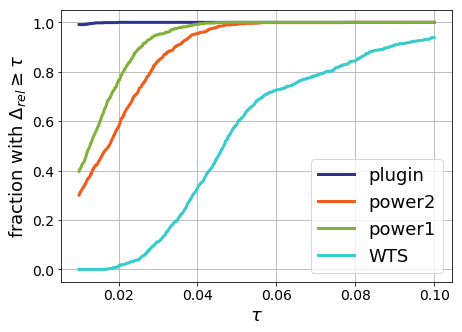

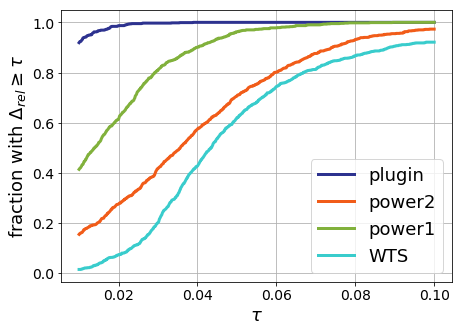

In [15]:
taus = []
rhos = []
for ix in range(4):
    tau, rrho = perf_prof(big_res[ix], big_hs[ix], ['plugin', 'power2', 'power1', 'WTS'], tau_min=0.01, tau_max=0.1, npts=1000)
#     plt.savefig('res_new' + str(ix) + '.png',dpi=300,bbox_inches='tight')
    taus.append(tau)
    rhos.append(rrho)

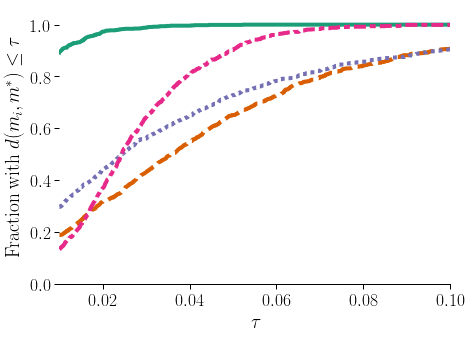

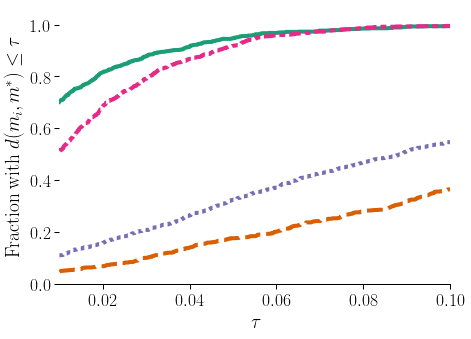

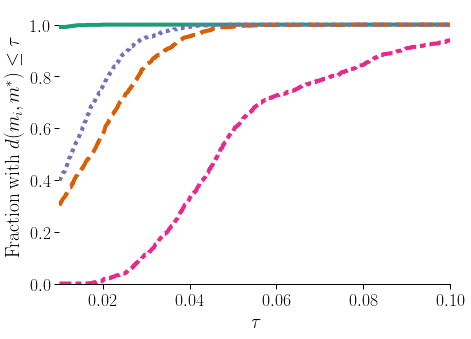

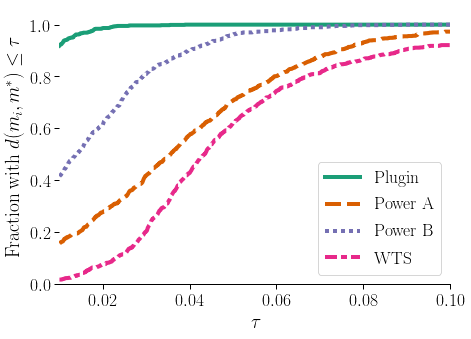

In [16]:
for ix in range(4):
    df = pd.DataFrame(rhos[ix], taus[ix])
    plt.rc('text', usetex=True)
    plt.rc('font', family='serif')
    sns.set_context("paper",font_scale=2)
    plt.figure(figsize=(7,5))
    g = sns.lineplot(data=df, palette="Dark2", linewidth=4, legend=False)
    # g2.set(yticks=[1,1.5,2])
    if ix==3:
        leg = plt.legend([r'Plugin', r'Power A', r'Power B', r'WTS'], framealpha=1.0)
    g.set_xlim(0.01,.1)
    g.set_ylim(0,1.05)

    g.set_ylabel(r'Fraction with $d(m_i,m^*)\leq \tau$')
    g.set_xlabel(r'$\tau$')
    sns.despine(left=True)
    plt.savefig('res_new' + str(ix) + '.pdf',dpi=1200,bbox_inches='tight')

In [10]:
from scipy.signal import convolve

In [11]:
convolve(np.random.rand(1000,10),np.random.rand(50))

ValueError: volume and kernel should have the same dimensionality